In [1]:

import seaborn as sn
import fnmatch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
import numpy as np
import torchvision
from  numpy import exp,absolute
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier as mlp
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
from torchmetrics.functional.classification import multiclass_confusion_matrix as mcm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score,f1_score,precision_score ,recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from pytorch_pretrained_vit import ViT
import random
import warnings
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import sklearn
import cv2
from PIL import Image


In [2]:
#hyper params
lr = 1e-6
wd = 1e-3
feature_extract = True
bs = 8
test_size = 0.15  # Test set size (20%)
val_size = 0.2   # Validation set size (25%)
num_epoch = 40
classes =[0,1,17,2,3,4] #arranged in order of their placement in the folder
num_classes = len(classes)
path = 'Irrelevant_Balanced'
hardness_threshold = 0.75
lambda_u = 0.1  # Weighting factor for the unsupervised loss
patience = 4

In [3]:
def transform_denoise(image):
    # Denoising transformation (replace with your denoising algorithm)
    # Example: Apply Gaussian blur with a kernel size of 3
    denoised_image = transforms.functional.gaussian_blur(image, kernel_size=3)
    return denoised_image

def transform_enhance(image):
    # Image enhancement transformation (replace with your enhancement algorithm)
    # Example: Apply contrast enhancement
    enhanced_image = transforms.functional.adjust_contrast(image, contrast_factor=1.5)
    return enhanced_image

In [4]:

def get_dataset(path,val_split,test_split):
    transform_weak = transforms.Compose([transforms.Resize((256,256)),
                                         transforms.Lambda(lambda x: transform_denoise(x)),
                                         transforms.Lambda(lambda x: transform_enhance(x)),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                               ])

    transform_strong = transforms.Compose([
                                        transforms.Resize((256, 256)),
                                        transforms.Lambda(lambda x: transform_denoise(x)),
                                        transforms.Lambda(lambda x: transform_enhance(x)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomCrop(size=256),
                                        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])


    dataset_strong = datasets.ImageFolder(path,transform=transform_strong)
    dataset_weak = datasets.ImageFolder(path,transform=transform_weak)

    trainset_strong,valset_strong,testset_strong = stratified(dataset_strong)
    trainset_weak,valset_weak,testset_weak = stratified(dataset_weak)
    
    print("train strong:",len(trainset_strong),"val strong:",len(valset_strong),"test strong:",len(testset_strong))
    print("train weak:",len(trainset_weak),"val weak:",len(valset_weak),"test strong:",len(testset_weak))

    
    return trainset_strong,valset_strong,testset_strong,trainset_weak,valset_weak,testset_weak

In [5]:
def stratified(dataset):
    # Get the labels and targets from the dataset
    labels = [label for _, label in dataset.samples]
    targets = dataset.targets

    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_val_indices, test_indices = next(stratified_split.split(targets, labels))

    train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)
    testset = torch.utils.data.Subset(dataset, test_indices)
    
    # Further split the train-val dataset into train and validation sets
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
    train_indices, val_indices = next(stratified_split.split(train_val_dataset, [labels[idx] for idx in train_val_indices]))

    trainset = torch.utils.data.Subset(train_val_dataset, train_indices)
    valset = torch.utils.data.Subset(train_val_dataset, val_indices)
    
    return trainset,valset,testset

In [6]:
def train_model(trainset_strong, valset_strong, trainset_weak,valset_weak, model, criterion, optimizer, scheduler_train, scheduler_val, num_epochs, bs, hardness_threshold):
    dataloaders_strong = {
        'train': data.DataLoader(trainset_strong, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset_strong, batch_size=bs, shuffle=True)
    }

    dataloaders_weak = {
        'train': data.DataLoader(trainset_weak, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset_weak, batch_size=bs, shuffle=True)
    }
    dataset_sizes_strong = {'train': len(trainset_strong), 'val': len(valset_strong)}
    dataset_sizes_weak = {'train': len(trainset_weak), 'val': len(valset_weak)}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_bal = 0.0
    epochs_without_improvement = 0  # Reset the counter since there is improvement

    # Lists to store entropy values for each epoch
    entropy_values_train = []
    entropy_values_val = []
    # Lists to store loss of each epoch
    E_loss_train = []
    E_loss_val = []
    # Lists to store balanced accuracy for training and validation phases
    balanced_acc_train = []
    balanced_acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        c = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            all_labels = []
            all_preds = []
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                        
            running_loss = 0.0
            running_corrects = 0
            epoch_entropy = 0.0  # Variable to store epoch entropy
            inputs = None
            labels = None
            # Iterate over data.
            for (inputs_strong, label_strong), (inputs_weak, labels_weak) in zip(dataloaders_strong[phase],dataloaders_weak[phase]):
                if phase == 'train':
                    inputs_strong = inputs_strong.to(device)
                    inputs_weak = inputs_weak.to(device)                
                    labels_weak = labels_weak.to(device)
                else:
                    inputs_val = inputs_strong.to(device)
                    labels_val = label_strong.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    # AdaMatch steps
                    if phase == 'train':
                        outputs_weak = model(inputs_weak)
                        _, preds_weak = torch.max(outputs_weak, 1)

                        #loss = criterion(outputs_weak, labels_weak)

                        # Calculate hardness score for each sample in the batch
                        probabilities_hard = torch.softmax(outputs_weak, dim=1)
                        hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]

                        # Skip predictions if hardness score is greater than the threshold
                        skip_mask = hardness_scores <= hardness_threshold
                    
                    
                        if skip_mask.sum().item() > 0:
                            c += 1
                            inputs_weak = inputs_weak[skip_mask]
                            labels_weak = labels_weak[skip_mask]
                            preds_weak = preds_weak[skip_mask]
                            #loss = criterion(outputs_weak[skip_mask], labels_weak)
                    
                        #skip_mask = skip_mask.unsqueeze(1).unsqueeze(2).unsqueeze(3).expand_as(inputs)  # Expand mask dimensions
                    
                    
                        outputs_strong = model(inputs_strong)
                        pseudo_labels = torch.softmax(outputs_strong.detach(), dim=1)
                        max_probs, pseudo_labels = torch.max(pseudo_labels, dim=1)
                        mask = max_probs.ge(0.95).float()

                        unsupervised_loss = (criterion(outputs_strong, pseudo_labels) * mask).mean()
                        loss = lambda_u * unsupervised_loss

                        outputs_strong = pseudo_labels.clone().detach()
                        inputs = torch.cat([inputs_weak, inputs_strong])
                        labels = torch.cat([labels_weak, outputs_strong])

                        supervised_outputs = model(inputs)
                        _, supervised_preds = torch.max(supervised_outputs, 1)
                        supervised_loss = criterion(supervised_outputs, labels)
                        loss += supervised_loss

                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        unique_classes_pred = np.unique(supervised_preds.cpu().numpy())
                        unique_classes_true = np.unique(labels.cpu().numpy())

                        if np.all(np.in1d(unique_classes_pred, unique_classes_true)):
                            balanced_acc = balanced_accuracy_score(labels.cpu(), supervised_preds.cpu())
                        else:
                            balanced_acc = 0.0  # Assign 0 if classes in y_pred not present in y_true

                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(supervised_preds.cpu().tolist())

                        # Backpropagation and optimization
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    else:
                        
                        # Calculate balanced accuracy for the validation phase without AdaMatch
                        inputs = inputs_val
                        labels = labels_val
                        supervised_outputs = model(inputs)
                        _, supervised_preds = torch.max(supervised_outputs, 1)
                        
                        loss = criterion(supervised_outputs, labels)
                                                    
                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        unique_classes_pred = np.unique(supervised_preds.cpu().numpy())
                        unique_classes_true = np.unique(labels.cpu().numpy())
                        
                        if np.all(np.in1d(unique_classes_pred, unique_classes_true)):
                            balanced_acc = balanced_accuracy_score(labels.cpu(), supervised_preds.cpu())
                        else:
                            balanced_acc = 0.0  # Assign 0 if classes in y_pred not present in y_true
                            
                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(supervised_preds.cpu().tolist())

                

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(supervised_preds == labels.data)

                # Calculate entropy for each batch and accumulate for epoch entropy
                probabilities = torch.softmax(supervised_outputs, dim=1)
                entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), dim=1)
                epoch_entropy += torch.sum(entropy)

            
            if phase == 'train':
                epoch_loss = running_loss / (dataset_sizes_strong[phase]+dataset_sizes_weak[phase])
                epoch_acc = running_corrects.double() / (dataset_sizes_strong[phase]+dataset_sizes_weak[phase])
                epoch_entropy /= (dataset_sizes_strong[phase]+dataset_sizes_weak[phase]) # Calculate average epoch entropy
            else:
                epoch_loss = running_loss / dataset_sizes_strong[phase]
                epoch_acc = running_corrects.double() / dataset_sizes_strong[phase]
                epoch_entropy /= dataset_sizes_strong[phase] # Calculate average epoch entropy
            
            if phase == 'train':
                scheduler_train.step()
                
            if phase == 'val':
                scheduler_val.step(epoch_loss)
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Epoch Entropy: {:.4f}'.format(phase, epoch_entropy.item()))
            print('{} Balanced Accuracy: {:.4f}'.format(phase, balanced_acc))
            print()

            if phase == 'train':
                # Save epoch entropy to the list
                entropy_values_train.append(epoch_entropy.item())
                # Save epoch loss to the list
                E_loss_train.append(epoch_loss)
                # Save epoch balanced loss to the list
                balanced_acc_train.append(balanced_acc)  # Append balanced accuracy for training
            else:
                # Save epoch entropy to the list
                entropy_values_val.append(epoch_entropy.item())
                # Save epoch loss to the list
                E_loss_val.append(epoch_loss)
                # Save epoch balanced loss to the list
                balanced_acc_val.append(balanced_acc)  # Append balanced accuracy for validation

            # Confusion Matrix
            cm = confusion_matrix(all_labels, all_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
            disp.plot()
            plt.figure(figsize=(8, 6))
            plt.show()

            # Deep copy the model if the validation accuracy improves
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch_val = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'val' and balanced_acc > best_bal:
                best_bal = balanced_acc
                best_epoch_bal = epoch
                
                
            # Early stopping criteria
            if phase == 'val' and epoch > 0:
                if epoch_loss >= E_loss_val[-1]:
                    epochs_without_improvement += 1
                else:
                    epochs_without_improvement = 0

                if epochs_without_improvement >= patience:
                    print('Early stopping due to no improvement in validation loss.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    ) 
                
            # Overfitting criteria
            if phase == 'train' and epoch_loss <= E_loss_train[-1]:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print('Training stopped due to overfitting.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    )
            else:
                epochs_without_improvement = 0
        print('Number of skipped:', c)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best Val Acc. was achieved at epoch', best_epoch_val)
    print('Best val Acc: {:4f}'.format(best_bal))
    print('Best Bal Val Acc. was achieved at epoch', best_epoch_bal)



    # Load best model weights
    model.load_state_dict(best_model_wts)

    return (
        model,
        entropy_values_train,
        entropy_values_val,
        E_loss_train,
        E_loss_val,
        balanced_acc_train,
        balanced_acc_val
    )
  

In [7]:
def test_model(model, testset):
    running_corrects = 0
    testloader = data.DataLoader(testset, batch_size=bs, shuffle=True)
    all_labels = []
    all_preds = []
    c = 0
    
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

              
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    test_accuracy = running_corrects / len(testset)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    print("The Test Accuracy:", test_accuracy)
    print("The Test Balanced Accuracy:", balanced_acc)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
    disp.plot()
    plt.figure(figsize=(8, 6))
    plt.show()


In [8]:

def weighted_score_array_adamatch(model,models,dataset_strong, dataset_weak):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader_strong = data.DataLoader(dataset_strong,batch_size=bs,shuffle=True)
    dataloader_weak = data.DataLoader(dataset_weak,batch_size=bs,shuffle=True)
    
    for (inputs_strong, _), (inputs_weak, labels_weak) in zip(dataloader_strong,dataloader_weak):
        inputs_strong = inputs_strong.to(device)
        inputs_weak = inputs_weak.to(device)                
        labels_weak = labels_weak.to(device)
        
        predictions = set()
        with torch.set_grad_enabled(False):
             # AdaMatch steps
            outputs_strong = model(inputs_strong)
            pseudo_labels = torch.softmax(outputs_strong.detach(), dim=1)
            max_probs, pseudo_labels = torch.max(pseudo_labels, dim=1)
            mask = max_probs.ge(0.95).float()

            unsupervised_loss = (criterion(outputs_strong, pseudo_labels) * mask).mean()

            outputs_strong = pseudo_labels.clone().detach()
            inputs = torch.cat([inputs_weak, inputs_strong])
            labels = torch.cat([labels_weak, outputs_strong])

            supervised_outputs = models[0](inputs)
            _, supervised_preds = torch.max(supervised_outputs, 1)
            predictions.add(supervised_preds)  
            
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                supervised_outputs = torch.cat((supervised_outputs,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,supervised_outputs.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,supervised_outputs.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [9]:

def weighted_score_array(model,models,dataset):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader = data.DataLoader(dataset,batch_size=64,shuffle=True)
    for inputs,labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        predictions = set()
        with torch.set_grad_enabled(False):
            x = models[0](inputs)
            _, preds = torch.max(x, 1)
            predictions.add(preds)
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                x = torch.cat((x,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,x.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,x.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [10]:
def set_parameter_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [11]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 256

    if model_name == "resnet":
        # Resnet50
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)
        
    elif model_name == "mobilenet":
        # Mobilenet_V2
        model_ft = torchvision.models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    elif model_name == "vgg":
        # VGG16_bn
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == "googlenet":
        # GoogLeNet
        model_ft = torchvision.models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(1024, num_classes)

    elif model_name == "densenet":
        # Densenet
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier = nn.Linear(1024, num_classes)

    elif model_name == "vit":
        # Vision Transformer (ViT)
        model_ft = ViT('B_16_imagenet1k', pretrained=True)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [12]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda:0


In [13]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Separate the train, val, and test sets
trainset_strong,valset_strong,testset_strong,trainset_weak,valset_weak,testset_weak = get_dataset(path, val_size, test_size)

train strong: 9942 val strong: 2486 test strong: 2194
train weak: 9942 val weak: 2486 test strong: 2194


In [14]:
def plot_distribution_by_class(dataset, classes):
    dataloaders = data.DataLoader(dataset,batch_size=bs,shuffle=True)
    count = [0] * len(classes)  # Initialize count list with zeros

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        
    
        for i in labels:
            count[i] += 1
    
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.bar(x, count)
    plt.xticks(x, classes)  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.show()

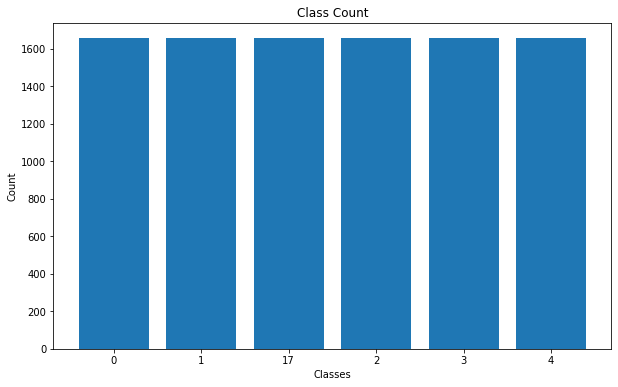

In [15]:
plot_distribution_by_class(trainset_strong, classes)

/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

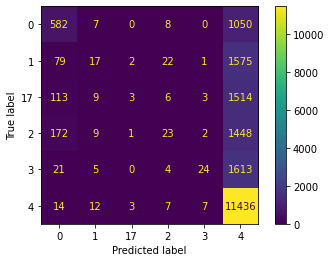

<Figure size 576x432 with 0 Axes>

val Loss: 2.7201 Acc: 0.1685
val Epoch Entropy: 1.2569
val Balanced Accuracy: 0.2000



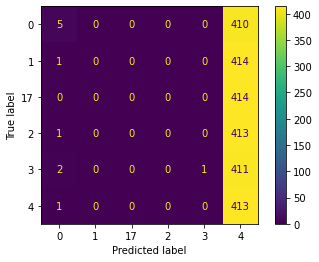

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 1/39
----------
train Loss: 0.9570 Acc: 0.6472
train Epoch Entropy: 1.7235
train Balanced Accuracy: 0.0000



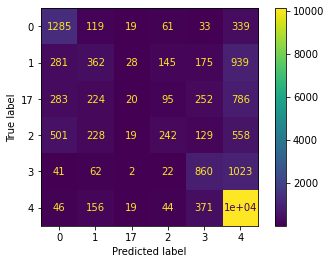

<Figure size 576x432 with 0 Axes>

val Loss: 3.3628 Acc: 0.1802
val Epoch Entropy: 0.8080
val Balanced Accuracy: 0.2500



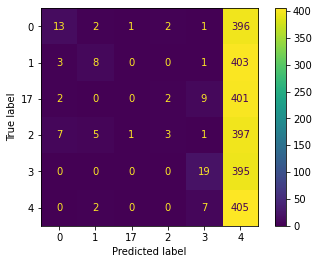

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 2/39
----------
train Loss: 0.9343 Acc: 0.6403
train Epoch Entropy: 1.5713
train Balanced Accuracy: 0.0000



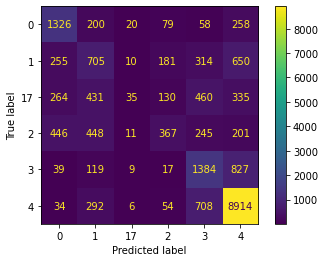

<Figure size 576x432 with 0 Axes>

val Loss: 3.7408 Acc: 0.1947
val Epoch Entropy: 0.6956
val Balanced Accuracy: 0.2500



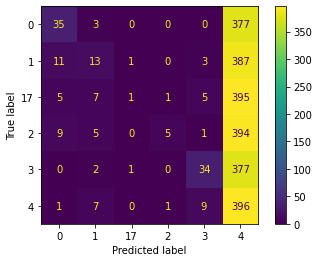

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 3/39
----------
train Loss: 0.9347 Acc: 0.6324
train Epoch Entropy: 1.5374
train Balanced Accuracy: 0.7000



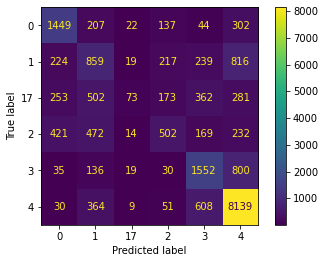

<Figure size 576x432 with 0 Axes>

val Loss: 3.9551 Acc: 0.2140
val Epoch Entropy: 0.7617
val Balanced Accuracy: 0.2000



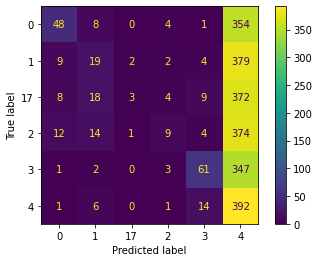

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 4/39
----------
train Loss: 0.9369 Acc: 0.6248
train Epoch Entropy: 1.5398
train Balanced Accuracy: 0.0000



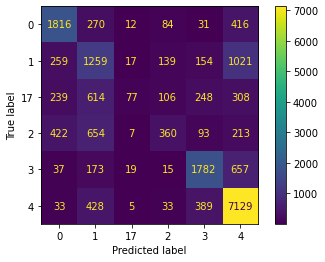

<Figure size 576x432 with 0 Axes>

val Loss: 3.5880 Acc: 0.2671
val Epoch Entropy: 0.9241
val Balanced Accuracy: 0.2500



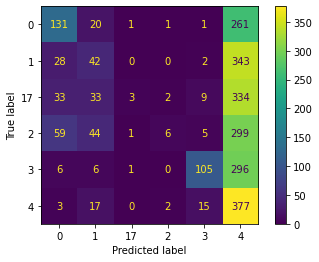

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 5/39
----------
train Loss: 0.9301 Acc: 0.6378
train Epoch Entropy: 1.5219
train Balanced Accuracy: 0.6667



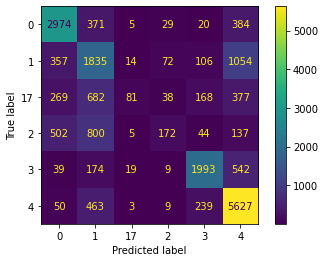

<Figure size 576x432 with 0 Axes>

val Loss: 3.0387 Acc: 0.3669
val Epoch Entropy: 0.9101
val Balanced Accuracy: 0.0000



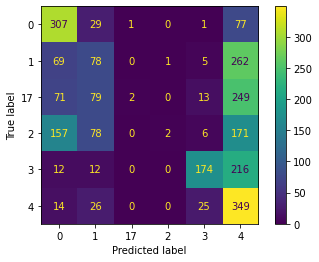

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 6/39
----------
train Loss: 0.8988 Acc: 0.6618
train Epoch Entropy: 1.4653
train Balanced Accuracy: 0.5000



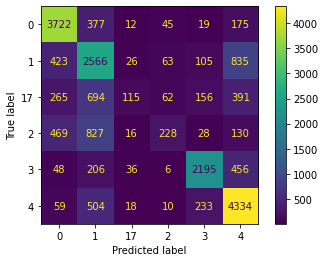

<Figure size 576x432 with 0 Axes>

val Loss: 2.5486 Acc: 0.4155
val Epoch Entropy: 0.8946
val Balanced Accuracy: 0.0000



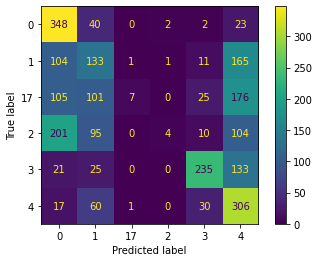

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 7/39
----------
train Loss: 0.8646 Acc: 0.6725
train Epoch Entropy: 1.4263
train Balanced Accuracy: 0.5333



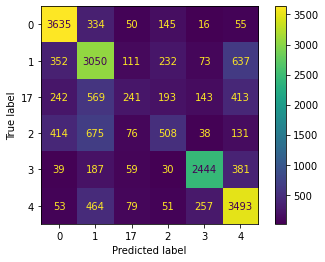

<Figure size 576x432 with 0 Axes>

val Loss: 2.4909 Acc: 0.4280
val Epoch Entropy: 0.8377
val Balanced Accuracy: 0.1000



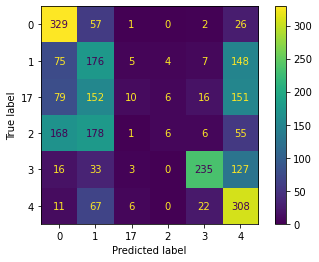

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 8/39
----------
train Loss: 0.8661 Acc: 0.6700
train Epoch Entropy: 1.3911
train Balanced Accuracy: 0.7667



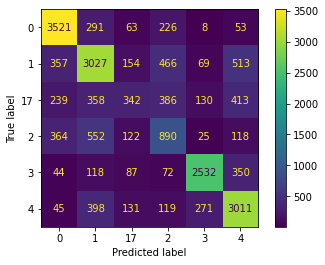

<Figure size 576x432 with 0 Axes>

val Loss: 2.1951 Acc: 0.4562
val Epoch Entropy: 0.9273
val Balanced Accuracy: 0.0000



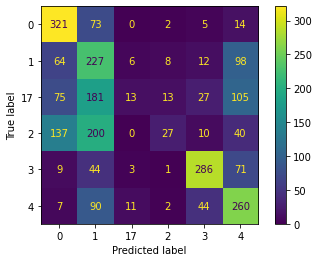

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 9/39
----------
train Loss: 0.8646 Acc: 0.6657
train Epoch Entropy: 1.3743
train Balanced Accuracy: 0.6944



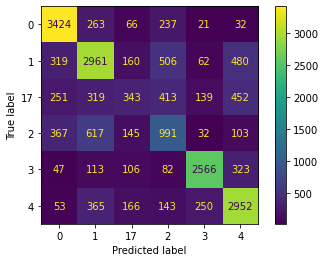

<Figure size 576x432 with 0 Axes>

val Loss: 2.3170 Acc: 0.4553
val Epoch Entropy: 0.8491
val Balanced Accuracy: 0.0000



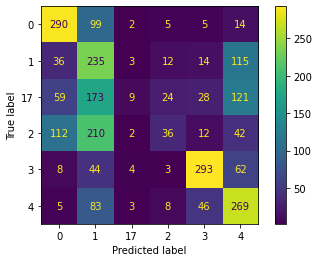

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 10/39
----------
train Loss: 0.8574 Acc: 0.6738
train Epoch Entropy: 1.3744
train Balanced Accuracy: 0.7000



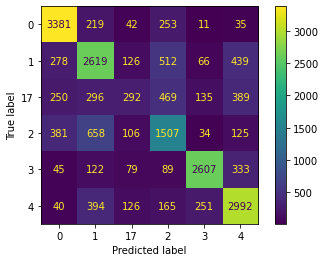

<Figure size 576x432 with 0 Axes>

val Loss: 2.3431 Acc: 0.4775
val Epoch Entropy: 0.8644
val Balanced Accuracy: 0.3000



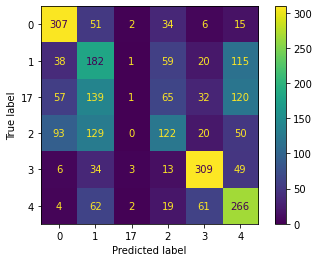

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 11/39
----------
train Loss: 0.8257 Acc: 0.6937
train Epoch Entropy: 1.3332
train Balanced Accuracy: 0.0000



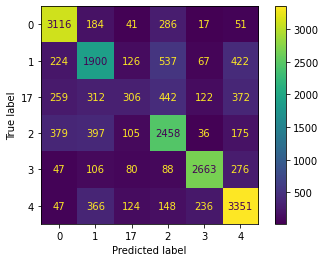

<Figure size 576x432 with 0 Axes>

val Loss: 2.2639 Acc: 0.4791
val Epoch Entropy: 0.8032
val Balanced Accuracy: 1.0000



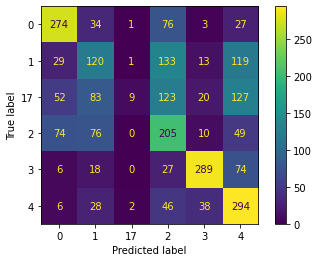

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 12/39
----------
train Loss: 0.8029 Acc: 0.7026
train Epoch Entropy: 1.2927
train Balanced Accuracy: 0.5500



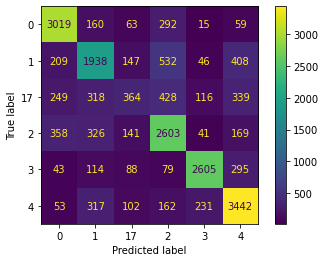

<Figure size 576x432 with 0 Axes>

val Loss: 2.2224 Acc: 0.4815
val Epoch Entropy: 0.8132
val Balanced Accuracy: 0.0000



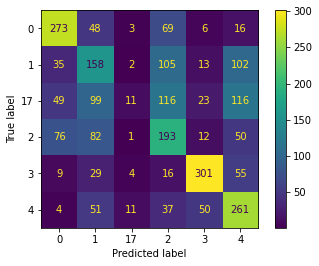

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 13/39
----------
train Loss: 0.7891 Acc: 0.7056
train Epoch Entropy: 1.2702
train Balanced Accuracy: 0.7778



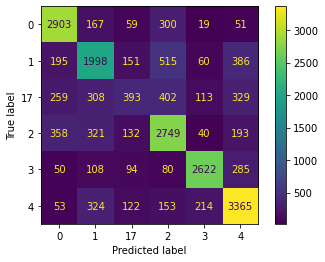

<Figure size 576x432 with 0 Axes>

val Loss: 2.3808 Acc: 0.4763
val Epoch Entropy: 0.7730
val Balanced Accuracy: 0.7500



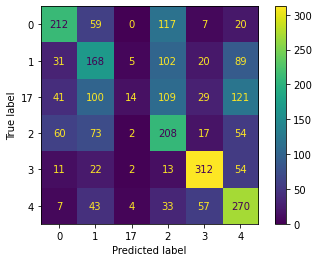

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 14/39
----------
train Loss: 0.7719 Acc: 0.7119
train Epoch Entropy: 1.2494
train Balanced Accuracy: 0.0000



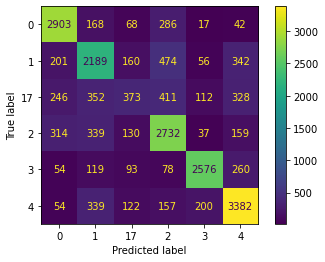

<Figure size 576x432 with 0 Axes>

val Loss: 2.6094 Acc: 0.4541
val Epoch Entropy: 0.7334
val Balanced Accuracy: 0.8333



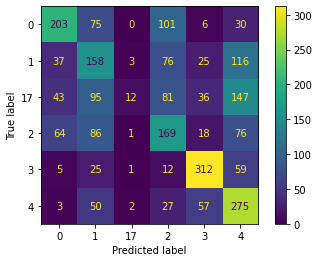

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 15/39
----------
train Loss: 0.7578 Acc: 0.7160
train Epoch Entropy: 1.2312
train Balanced Accuracy: 0.8833



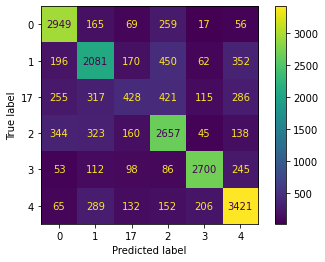

<Figure size 576x432 with 0 Axes>

val Loss: 2.6276 Acc: 0.4586
val Epoch Entropy: 0.6916
val Balanced Accuracy: 0.0000



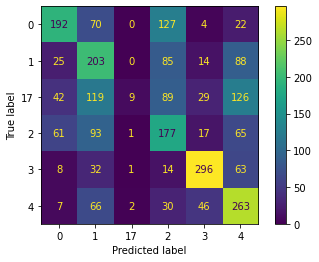

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 16/39
----------
train Loss: 0.7507 Acc: 0.7208
train Epoch Entropy: 1.2158
train Balanced Accuracy: 0.0000



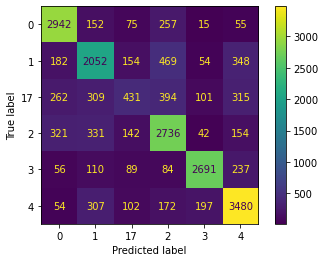

<Figure size 576x432 with 0 Axes>

val Loss: 2.4723 Acc: 0.4578
val Epoch Entropy: 0.7544
val Balanced Accuracy: 0.0000



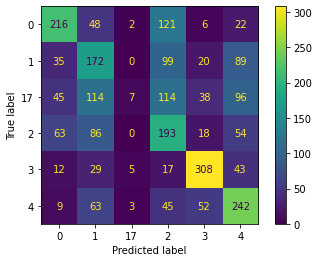

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 17/39
----------
train Loss: 0.7537 Acc: 0.7186
train Epoch Entropy: 1.2118
train Balanced Accuracy: 0.6111



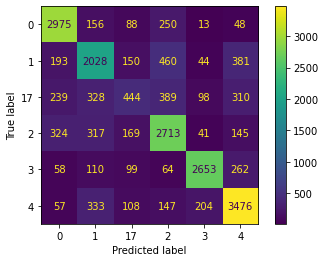

<Figure size 576x432 with 0 Axes>

val Loss: 2.6017 Acc: 0.4658
val Epoch Entropy: 0.7018
val Balanced Accuracy: 0.0000



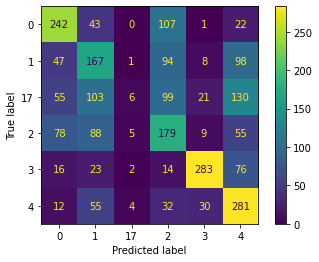

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 18/39
----------
train Loss: 0.7433 Acc: 0.7238
train Epoch Entropy: 1.2058
train Balanced Accuracy: 0.0000



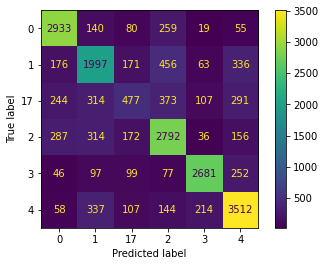

<Figure size 576x432 with 0 Axes>

val Loss: 2.4822 Acc: 0.4755
val Epoch Entropy: 0.7478
val Balanced Accuracy: 0.0000



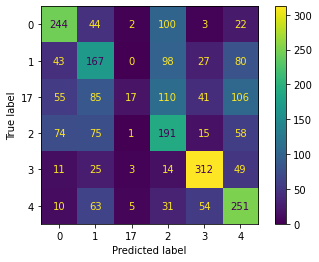

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 19/39
----------
train Loss: 0.7431 Acc: 0.7247
train Epoch Entropy: 1.1980
train Balanced Accuracy: 0.0000



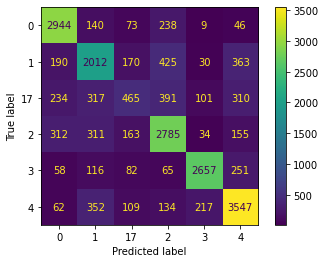

<Figure size 576x432 with 0 Axes>

val Loss: 2.6534 Acc: 0.4537
val Epoch Entropy: 0.7140
val Balanced Accuracy: 0.5833



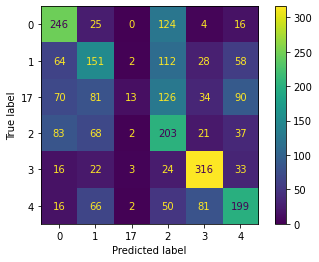

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 20/39
----------
train Loss: 0.7375 Acc: 0.7271
train Epoch Entropy: 1.1936
train Balanced Accuracy: 0.8472



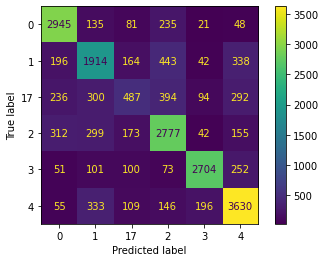

<Figure size 576x432 with 0 Axes>

val Loss: 2.6800 Acc: 0.4545
val Epoch Entropy: 0.7148
val Balanced Accuracy: 0.0000



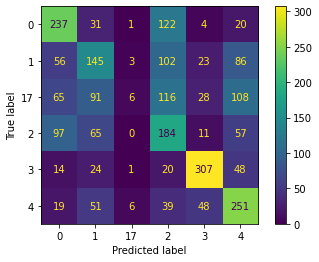

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 21/39
----------
train Loss: 0.7341 Acc: 0.7231
train Epoch Entropy: 1.1867
train Balanced Accuracy: 0.6667



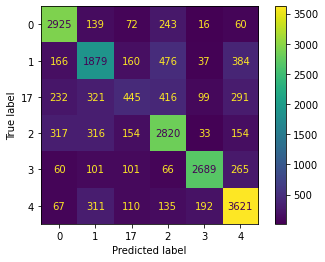

<Figure size 576x432 with 0 Axes>

val Loss: 2.6344 Acc: 0.4481
val Epoch Entropy: 0.7176
val Balanced Accuracy: 0.0000



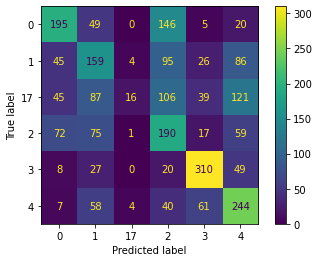

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 22/39
----------
train Loss: 0.7355 Acc: 0.7261
train Epoch Entropy: 1.1933
train Balanced Accuracy: 0.6111



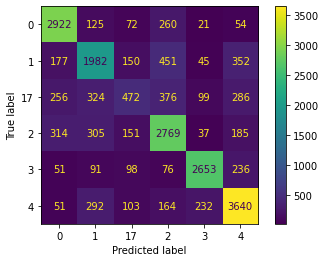

<Figure size 576x432 with 0 Axes>

val Loss: 2.8580 Acc: 0.4570
val Epoch Entropy: 0.6479
val Balanced Accuracy: 0.0000



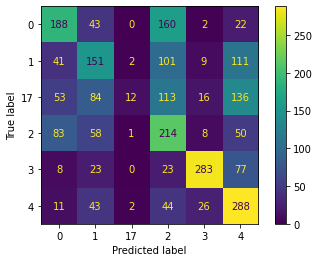

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 23/39
----------
train Loss: 0.7350 Acc: 0.7279
train Epoch Entropy: 1.1813
train Balanced Accuracy: 0.0000



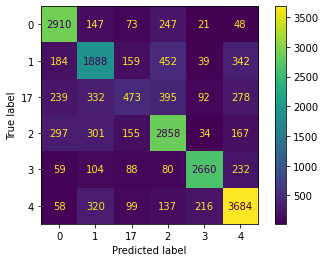

<Figure size 576x432 with 0 Axes>

val Loss: 2.8863 Acc: 0.4288
val Epoch Entropy: 0.6861
val Balanced Accuracy: 0.0000



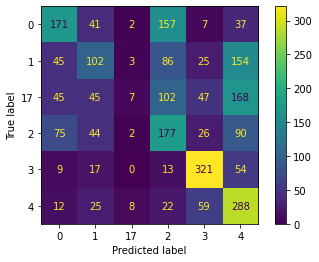

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 24/39
----------
train Loss: 0.7273 Acc: 0.7278
train Epoch Entropy: 1.1829
train Balanced Accuracy: 0.8333



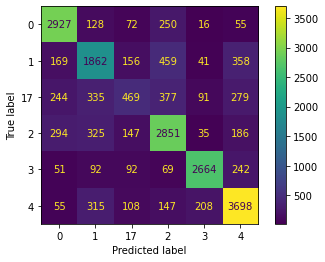

<Figure size 576x432 with 0 Axes>

val Loss: 2.7715 Acc: 0.4574
val Epoch Entropy: 0.6478
val Balanced Accuracy: 0.0000



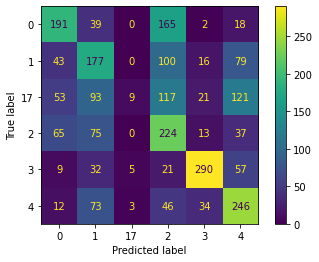

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 25/39
----------
train Loss: 0.7341 Acc: 0.7229
train Epoch Entropy: 1.1812
train Balanced Accuracy: 0.8667



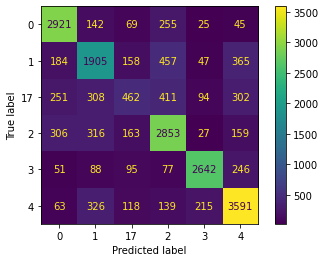

<Figure size 576x432 with 0 Axes>

val Loss: 2.7089 Acc: 0.4409
val Epoch Entropy: 0.6805
val Balanced Accuracy: 0.0000



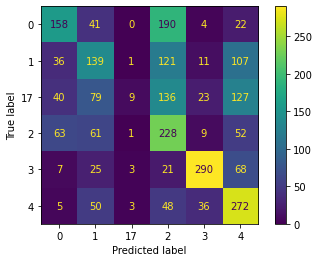

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 26/39
----------
train Loss: 0.7336 Acc: 0.7249
train Epoch Entropy: 1.1835
train Balanced Accuracy: 0.5556



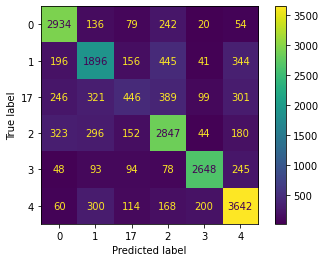

<Figure size 576x432 with 0 Axes>

val Loss: 2.7276 Acc: 0.4586
val Epoch Entropy: 0.6817
val Balanced Accuracy: 0.0000



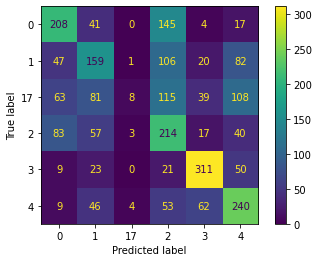

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 27/39
----------
train Loss: 0.7288 Acc: 0.7264
train Epoch Entropy: 1.1783
train Balanced Accuracy: 0.6944



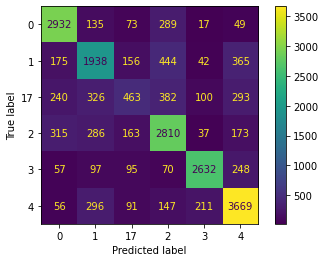

<Figure size 576x432 with 0 Axes>

val Loss: 2.8423 Acc: 0.4521
val Epoch Entropy: 0.6422
val Balanced Accuracy: 0.0000



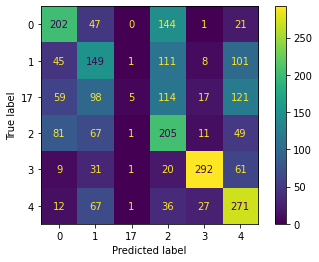

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 28/39
----------
train Loss: 0.7338 Acc: 0.7255
train Epoch Entropy: 1.1849
train Balanced Accuracy: 0.7222



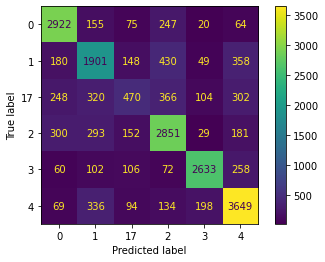

<Figure size 576x432 with 0 Axes>

val Loss: 2.6054 Acc: 0.4489
val Epoch Entropy: 0.7271
val Balanced Accuracy: 0.0000



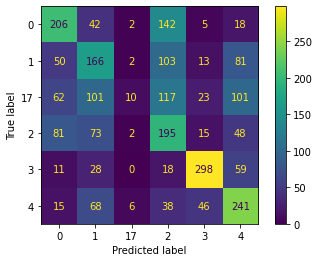

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 29/39
----------
train Loss: 0.7346 Acc: 0.7231
train Epoch Entropy: 1.1784
train Balanced Accuracy: 0.0000



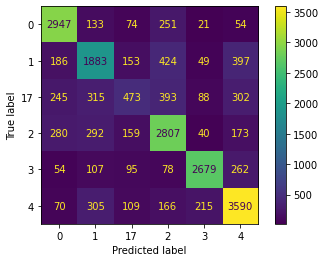

<Figure size 576x432 with 0 Axes>

val Loss: 2.6862 Acc: 0.4586
val Epoch Entropy: 0.6913
val Balanced Accuracy: 0.0000



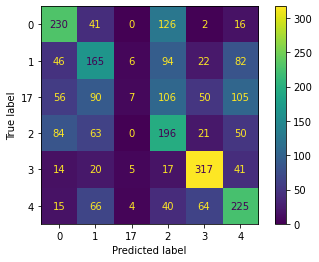

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 30/39
----------
train Loss: 0.7336 Acc: 0.7258
train Epoch Entropy: 1.1809
train Balanced Accuracy: 0.0000



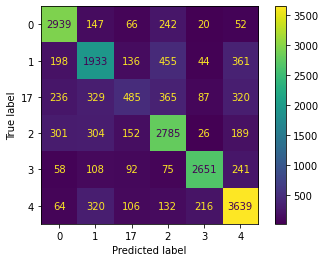

<Figure size 576x432 with 0 Axes>

val Loss: 2.6108 Acc: 0.4405
val Epoch Entropy: 0.7626
val Balanced Accuracy: 0.0000



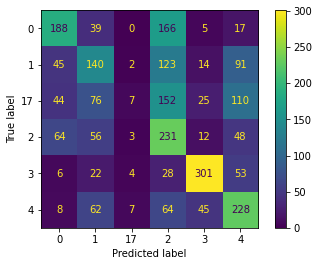

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 31/39
----------
train Loss: 0.7399 Acc: 0.7227
train Epoch Entropy: 1.1826
train Balanced Accuracy: 0.0000



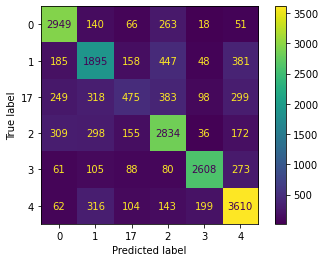

<Figure size 576x432 with 0 Axes>

val Loss: 2.8964 Acc: 0.4610
val Epoch Entropy: 0.6172
val Balanced Accuracy: 0.0000



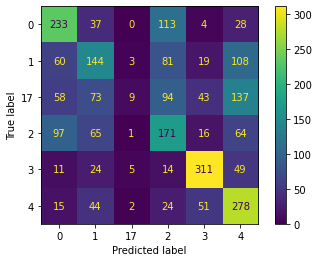

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 32/39
----------
train Loss: 0.7286 Acc: 0.7251
train Epoch Entropy: 1.1819
train Balanced Accuracy: 0.8533



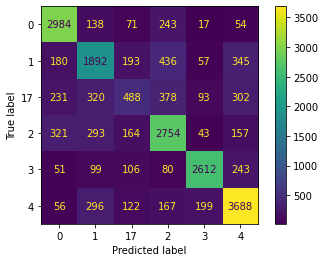

<Figure size 576x432 with 0 Axes>

val Loss: 2.6813 Acc: 0.4570
val Epoch Entropy: 0.7048
val Balanced Accuracy: 0.4000



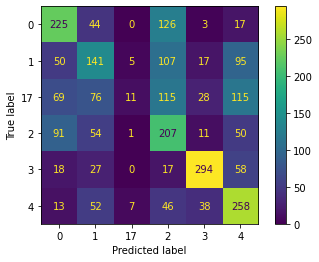

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 33/39
----------
train Loss: 0.7324 Acc: 0.7257
train Epoch Entropy: 1.1840
train Balanced Accuracy: 0.7167



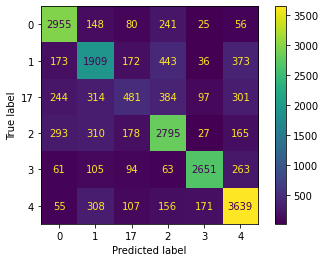

<Figure size 576x432 with 0 Axes>

val Loss: 2.6904 Acc: 0.4570
val Epoch Entropy: 0.6975
val Balanced Accuracy: 0.0000



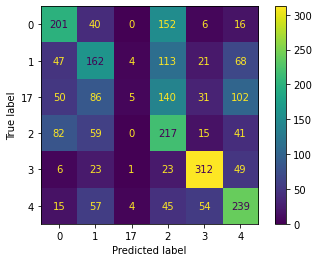

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 34/39
----------
train Loss: 0.7313 Acc: 0.7283
train Epoch Entropy: 1.1832
train Balanced Accuracy: 0.8333



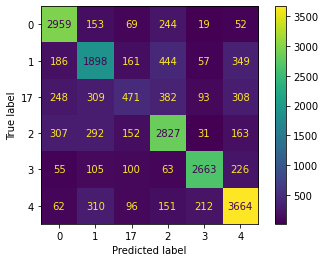

<Figure size 576x432 with 0 Axes>

val Loss: 2.8790 Acc: 0.4493
val Epoch Entropy: 0.6485
val Balanced Accuracy: 0.0000



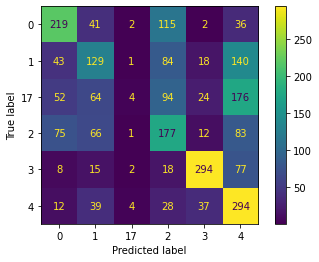

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 35/39
----------
train Loss: 0.7316 Acc: 0.7246
train Epoch Entropy: 1.1823
train Balanced Accuracy: 0.0000



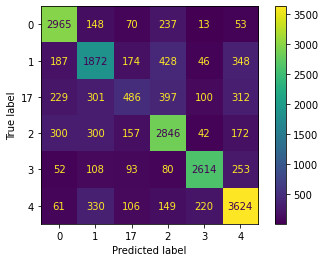

<Figure size 576x432 with 0 Axes>

val Loss: 2.5533 Acc: 0.4666
val Epoch Entropy: 0.7294
val Balanced Accuracy: 0.7000



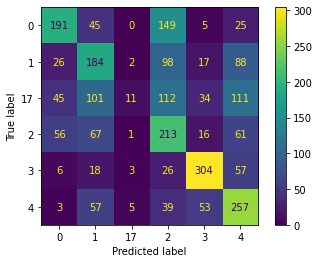

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 36/39
----------
train Loss: 0.7307 Acc: 0.7269
train Epoch Entropy: 1.1769
train Balanced Accuracy: 0.5222



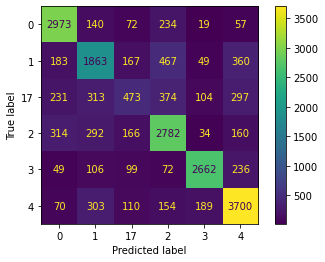

<Figure size 576x432 with 0 Axes>

val Loss: 2.5396 Acc: 0.4481
val Epoch Entropy: 0.7918
val Balanced Accuracy: 0.0000



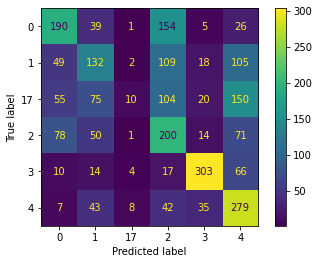

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 37/39
----------
train Loss: 0.7312 Acc: 0.7286
train Epoch Entropy: 1.1840
train Balanced Accuracy: 0.0000



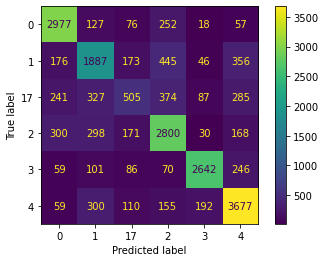

<Figure size 576x432 with 0 Axes>

val Loss: 2.6042 Acc: 0.4650
val Epoch Entropy: 0.7164
val Balanced Accuracy: 0.0000



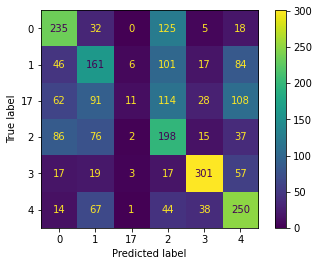

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 38/39
----------
train Loss: 0.7338 Acc: 0.7240
train Epoch Entropy: 1.1847
train Balanced Accuracy: 0.7083



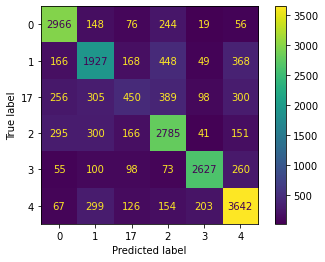

<Figure size 576x432 with 0 Axes>

val Loss: 2.7264 Acc: 0.4614
val Epoch Entropy: 0.6924
val Balanced Accuracy: 0.8000



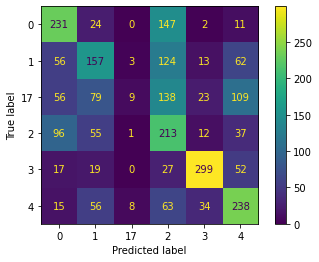

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Epoch 39/39
----------
train Loss: 0.7268 Acc: 0.7289
train Epoch Entropy: 1.1800
train Balanced Accuracy: 0.7917



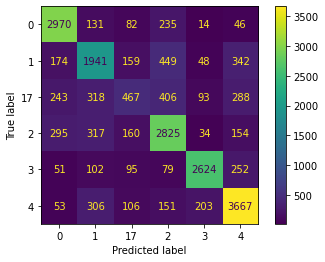

<Figure size 576x432 with 0 Axes>

val Loss: 2.5700 Acc: 0.4541
val Epoch Entropy: 0.7070
val Balanced Accuracy: 0.0000



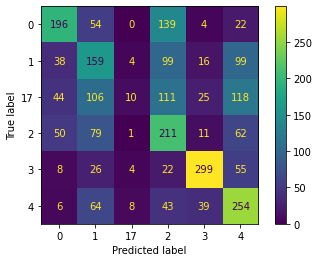

<Figure size 576x432 with 0 Axes>

Number of skipped: 1243

Training complete in 198m 59s
Best val Acc: 0.481496
Best Val Acc. was achieved at epoch 12
Best val Acc: 1.000000
Best Bal Val Acc. was achieved at epoch 11


In [14]:
model_list = []
for model_name in ["resnet"]:
    
    # Initialize the model
    model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    
    model_list.append(model)
    
    # Send model to GPU, if available
    model = model.to(device)
    
    params_to_update = model.parameters()
    
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print("\t", name)
    
    # Observe that all parameters are being optimized
    optimizer = optim.Adamax(params_to_update, lr=lr)

    exp_lr_scheduler_train = lr_scheduler.StepLR(optimizer, step_size=5, gamma=2)
    exp_lr_scheduler_val = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-9)



    
    model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val = train_model(trainset_strong, valset_strong,trainset_weak,valset_weak, model, criterion, optimizer, exp_lr_scheduler_train,exp_lr_scheduler_val, num_epoch, bs,hardness_threshold)
    


The Test Accuracy: tensor(0.4872, device='cuda:0')
The Test Balanced Accuracy: 0.4872707537989371


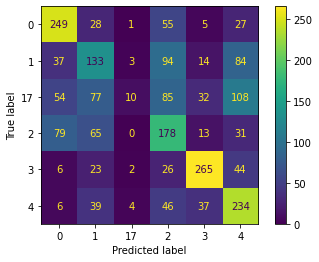

<Figure size 576x432 with 0 Axes>

In [15]:
test_model(model, testset_strong)


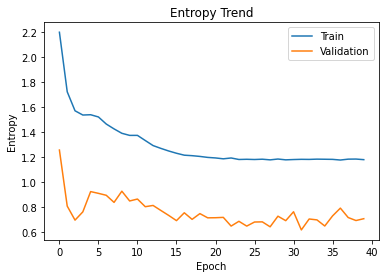

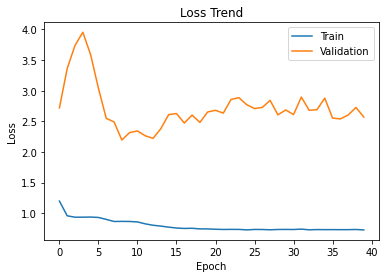

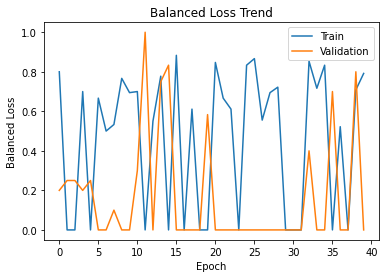

In [16]:

import matplotlib.pyplot as plt

# Plot entropy values
plt.figure()
plt.plot(entropy_values_train, label='Train')
plt.plot(entropy_values_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy Trend')
plt.legend()
plt.show()

# Plot loss values
plt.figure()
plt.plot(E_loss_train, label='Train')
plt.plot(E_loss_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

# Plot balanced loss values
plt.figure()
plt.plot(balanced_acc_train, label='Train')
plt.plot(balanced_acc_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Balanced Loss')
plt.title('Balanced Loss Trend')
plt.legend()
plt.show()


In [17]:
train_X, train_Y = weighted_score_array_adamatch(model,model_list, trainset_strong, trainset_weak)
test_X, test_Y = weighted_score_array(model, model_list, testset_strong)


In [18]:

#make a dummy prediction, i.e Random Baseline
# Create a dummy classifier with a strategy
dummy_clf = DummyClassifier(strategy='uniform')

# Train the dummy classifier
dummy_clf.fit(train_X, train_Y)

# Make predictions on the test set
predictions = dummy_clf.predict(test_X)

# Evaluate the accuracy of the dummy classifier
accuracy = dummy_clf.score(test_X, test_Y)

#Balanced Accuracy
balanced_acc = balanced_accuracy_score(test_Y, predictions)  # Calculate balanced accuracy


print("Dummy Classifier Accuracy/ Random Baseline:", accuracy)

print("Dummy Classifier Balanced Accuracy/ Random Baseline:", balanced_acc)



Dummy Classifier Accuracy/ Random Baseline: 0.16773017319963537
Dummy Classifier Balanced Accuracy/ Random Baseline: 0.16362751702971778


Accuracy for SVM: 0.487693710118505
Balanced Accuracy:0.4877585647628315


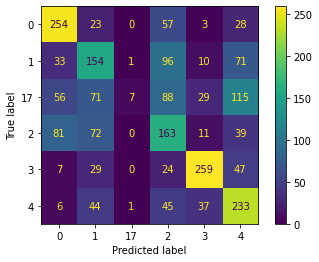

<Figure size 576x432 with 0 Axes>

In [19]:
    
# Predict using SVM
model_svc = SVC(decision_function_shape='ovr', C=500, kernel='rbf')
model_svc.fit(train_X, train_Y)
pred = model_svc.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for SVM: ' + str(acc))
balanced_svm = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_svm))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

Accuracy for MLP: 0.4822242479489517
Balanced Accuracy:0.4822841031015295


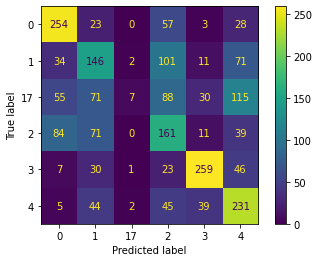

<Figure size 576x432 with 0 Axes>

In [20]:
# Predict using MLP
model_mlp = mlp(solver='lbfgs', alpha=1e-5, random_state=5, max_iter=100000)
model_mlp.fit(train_X, train_Y)
pred = model_mlp.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for MLP: ' + str(acc))
balanced_mlp = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_mlp))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()